In [94]:
from io import StringIO
import os
import boto3
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


In [77]:
aws_acces_key_id = os.getenv("AWS_ACCES_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [78]:
aws_acces_key_id
aws_secret_key

'mJ1fXM71vcBwySBp7i2p8l0OOr/M457BHlwnsH3I'

In [79]:
def read_csv_from_s3(bucket : str, path: str, filename: str) -> pd.DataFrame:
    """Downloads csv file from an S3 bucket

    bucket : str
        The bucket wehere the files at
    path : str
        The folders to the file
    filename : str
        Name of the file

    Returns:
        DataFrame of the downlaoded file
    """
    
    s3 = boto3.client("s3",aws_access_key_id = aws_acces_key_id , aws_secret_access_key = aws_secret_key)
    full_path = f"{path}{filename}"
    
    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object["Body"].read().decode("utf-8") 
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [80]:
s3 = boto3.client("s3",aws_access_key_id = aws_acces_key_id , aws_secret_access_key = aws_secret_key)
bucket =  "cubixdatachicagobm"
community_areas_path = "transformed_data/community_areas/"
payment_type_path = "transformed_data/payment_type /"
company_path = "transformed_data/company /"
date_path = "transformed_data/date/"
payment_type_path = "transformed_data/payment_type /"
taxi_trips_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"

In [81]:
trips_list = []
weather_list = []

In [82]:

community_areas = read_csv_from_s3(bucket, community_areas_path , "community_areas_master.csv")
payment_type = read_csv_from_s3(bucket=bucket, path=payment_type_path, filename= "payment_type_master.csv")
company = read_csv_from_s3(bucket=bucket, path=company_path, filename= "company_master.csv")
date = read_csv_from_s3(bucket=bucket, path=date_path, filename= "05_date_dimension.csv")


In [83]:
# TAXI DATA TRANSFORMATION AND LOADING
for file in s3.list_objects(Bucket = bucket , Prefix = taxi_trips_path )['Contents']:
    taxi_trip_key = file["Key"]
        
    if taxi_trip_key.split("/")[-1].strip() != "":
        if taxi_trip_key.split(".")[1] == "csv":
                
            filename = taxi_trip_key.split("/")[-1]
            print(filename)
            trip = read_csv_from_s3(bucket, taxi_trips_path, filename)

            trips_list.append(trip)
            print(f"{filename} has been added")

               

taxi_2021-06-26.csv
taxi_2021-06-26.csv has been added
taxi_2021-06-27.csv
taxi_2021-06-27.csv has been added


In [84]:
weather_list

[]

In [85]:
trips = pd.concat(trips_list, ignore_index= True)
trips.sample(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area_id,dropoff_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,company_id
1598,2dcfa8d7814e0c8cb0a1b4be8f1dc94741d1b7d3,31be1d0f5781cd789da14c7d6ad558cc03898eba376986...,2021-06-26 20:00:00,2021-06-26T20:00:00.000,1,0.0,14,14,3.25,0.0,0.0,0.5,3.75,41.968069,-87.721559,41.968069,-87.721559,2021-06-26 20:00:00,1,2


In [86]:
for file in s3.list_objects(Bucket = bucket , Prefix = weather_path )['Contents']:
    weather_key = file["Key"]
        
    if weather_key.split("/")[-1].strip() != "":
        if weather_key.split(".")[1] == "csv":
                
            filename = weather_key.split("/")[-1]
            weather_daily = read_csv_from_s3(bucket, weather_path, filename)

            weather_list.append(weather_daily)
            print(f"{filename} has been added")

weather_2021-06-26.csv has been added
weather_2021-06-27.csv has been added


In [87]:
weather = pd.concat(weather_list)
weather.sample()

,datetime,temperature,windspeed,rain,precipitation
13,2021-06-27 13:00:00,23.7,26.3,0.0,0.0


In [88]:
community_areas.head()
company.head()
date.head()
payment_type.head()

,payment_type_id,payment_type
0,1,Cash
1,2,Credit Card
2,3,Prcard
3,4,Mobile
4,5,Unknown


#### JOIN THEM TOGETHER

In [89]:
trips_full = pd.merge(trips,weather,left_on = "datetime_for_weather" , right_on= "datetime" , how= "inner")
trips_full = trips_full.drop(columns=["datetime"])

trips_full = pd.merge(trips,company ,left_on = "company_id" , right_on= "company_id" , how= "inner")
trips_full = trips_full.drop(columns=["company_id"])

trips_full = pd.merge(trips,payment_type,left_on = "payment_type_id" , right_on= "payment_type_id" , how= "inner")
trips_full = trips_full.drop(columns=["payment_type_id"])

trips_full = pd.merge(trips,community_areas,left_on = "pickup_community_area_id" , right_on= "area_code" , how= "inner")
trips_full = trips_full.drop(columns=["pickup_community_area_id"])
trips_full.rename(columns={"community_name":"pickup_community_area_name"}, inplace=True)

trips_full = pd.merge(trips,community_areas,left_on = "dropoff_community_area_id" , right_on= "area_code" , how= "inner")
trips_full = trips_full.drop(columns=["dropoff_community_area_id"])
trips_full.rename(columns={"community_name":"dropoff_community_area_name"}, inplace=True)


In [91]:
date['date'] = pd.to_datetime(date['date'])
date['date'] = date['date'] - pd.DateOffset(months=35)
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])
trips_full["trip_start_date"] = trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] = pd.to_datetime(trips_full["trip_start_date"])

In [92]:
trips_full = pd.merge(trips_full, date,left_on = "trip_start_date" , right_on= "date" , how= "inner")
trips_full = trips_full.drop(columns=["date"])


In [98]:
trips_full_sample = trips_full.sample(1)
trips_full_sample.to_csv("sample.csv", index=False)

In [116]:
trips_full.sample(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,company_id,area_code,dropoff_community_area_name,area code,trip_start_date,year,month,day,day_of_week,is_weekend
9729,10fa904cf08705416048eccb355a148646946d97,02829774801528933cdce279a9ebc9dbab805ccd5e5b52...,2021-06-27 06:00:00,2021-06-27T06:15:00.000,661,12.55,76,31.25,0.0,0.0,0.0,31.25,41.980264,-87.913625,41.901207,-87.676356,2021-06-27 06:00:00,3,2,24,West Town,24,2021-06-27,2024,5,27,1,False


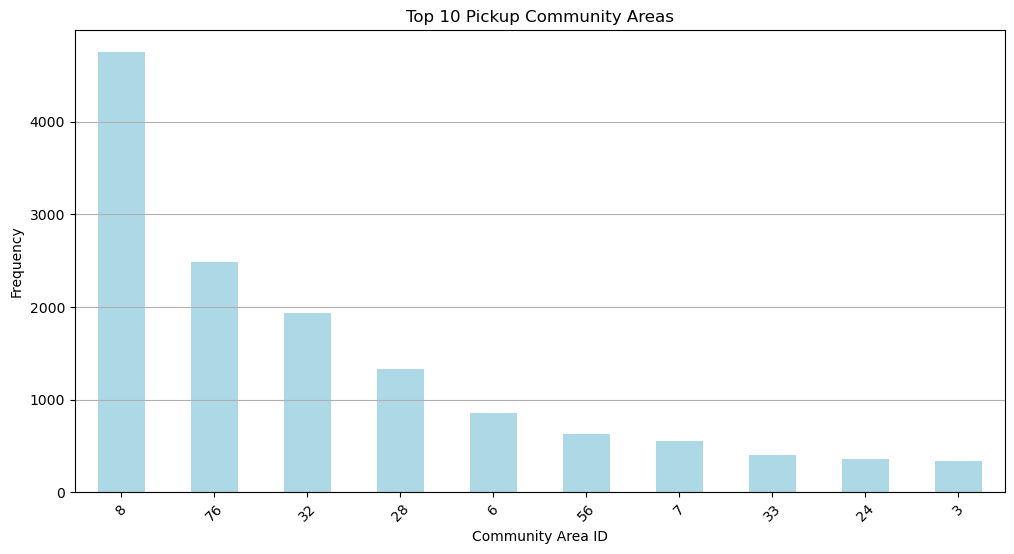

In [127]:
top_pickup_areas = trips_full['pickup_community_area_id'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_pickup_areas.plot(kind='bar', color='lightblue')
plt.title('Top 10 Pickup Community Areas')
plt.xlabel('Community Area ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



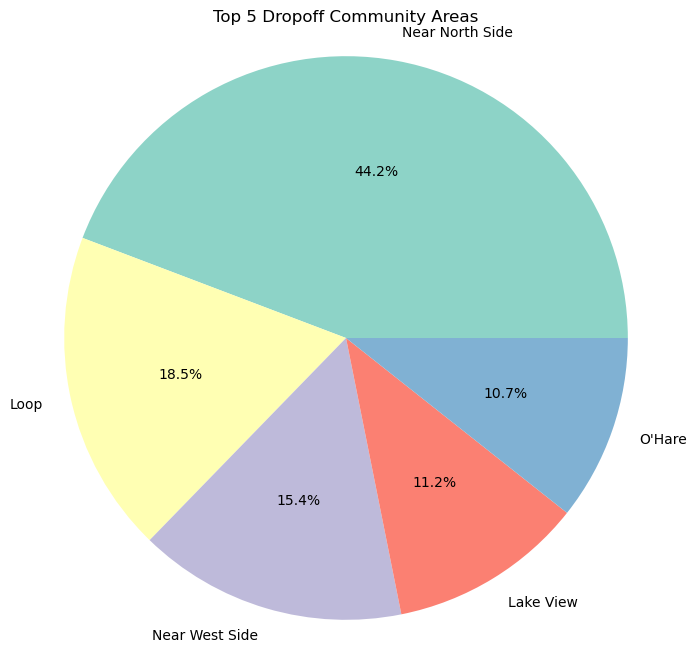

In [130]:
plt.figure(figsize=(8, 8))
dropoff_counts = trips_full['dropoff_community_area_name'].value_counts().head(5)
plt.pie(dropoff_counts, labels=dropoff_counts.index, autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.title('Top 5 Dropoff Community Areas')
plt.axis('equal')
plt.show()

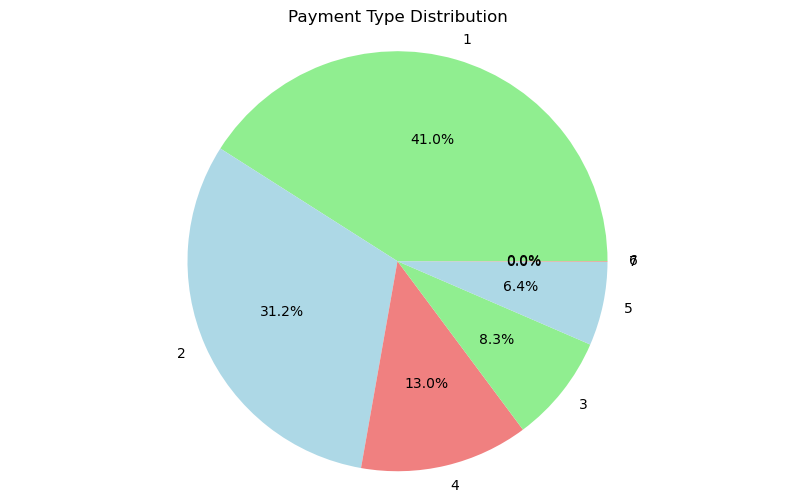

In [109]:

plt.figure(figsize=(10, 6))
payment_sizes = trips_full['payment_type_id'].value_counts(normalize=True)
plt.pie(payment_sizes, labels=payment_sizes.index, autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Payment Type Distribution')
plt.axis('equal')
plt.show()



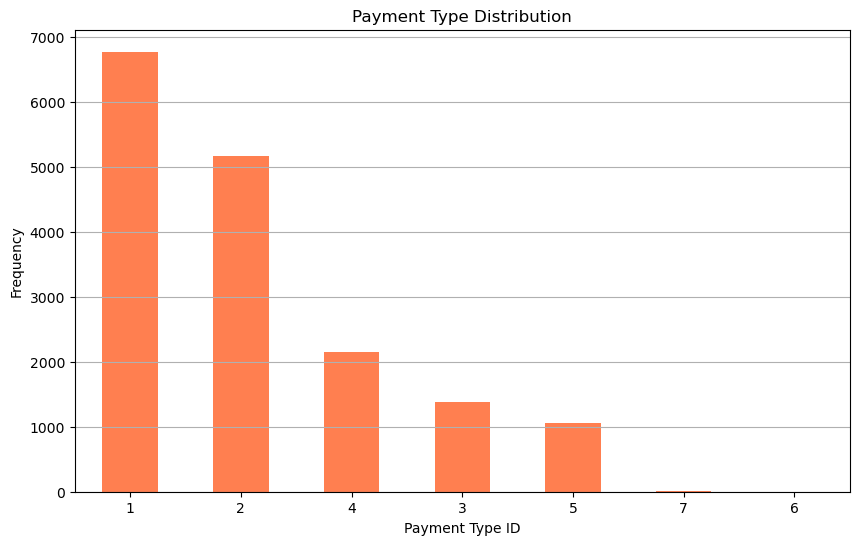

In [117]:
plt.figure(figsize=(10, 6))
payment_counts = trips_full['payment_type_id'].value_counts()
payment_counts.plot(kind='bar', color='coral')
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type ID')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

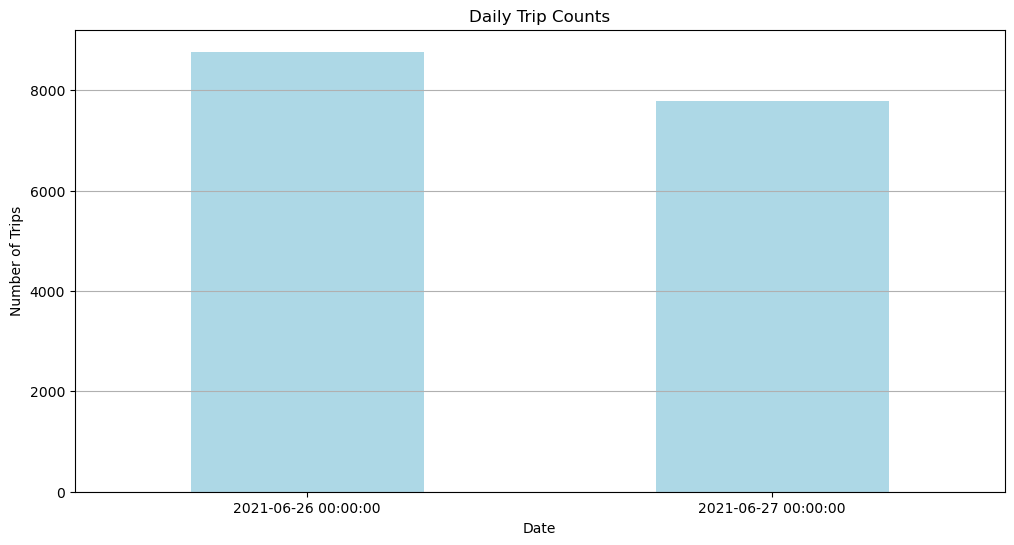

In [122]:
daily_counts = trips_full['trip_start_date'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='lightblue')
plt.title('Daily Trip Counts')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation = 0)
plt.grid(axis='y')
plt.show()